In [1]:
# ENHANCED Data Fusion Pipeline - Imports and Configuration
import time
import torch
import warnings
import numpy as np
import torch.nn as nn
import seaborn as sns
from PIL import Image
from pathlib import Path
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomRotation, ColorJitter, RandomHorizontalFlip, RandomResizedCrop, TrivialAugmentWide
from skimage.feature import local_binary_pattern
import pickle
import os
import joblib

warnings.filterwarnings("ignore")

# ENHANCED Configuration
IMG_SIZE = 224
BATCH_SIZE = 16
STAGE1_LR = 1e-3          # ENHANCEMENT: Stage 1 - LBP branch training
STAGE2_LR = 5e-5          # ENHANCEMENT: Stage 2 - End-to-end fine-tuning  
STAGE1_EPOCHS = 50        # ENHANCEMENT: Two-stage training
STAGE2_EPOCHS = 100
TOTAL_EPOCHS = STAGE1_EPOCHS + STAGE2_EPOCHS
PATIENCE = 20
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

# ImageNet normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# ENHANCED LBP parameters  
LBP_RADIUS = 2            # ENHANCEMENT: Larger radius for richer texture features
LBP_N_POINTS = 16         # ENHANCEMENT: More points for better discrimination
LBP_FEATURE_DIM = 18      # 16 + 2 for uniform LBP

print("🔬 ENHANCED DATA FUSION PIPELINE")
print("=" * 60)
print(f"   Device: {DEVICE}")
print(f"   Strategy: Two-Stage Training + Gated Fusion")
print(f"   Architecture: Fine-tuned CNN + Enhanced LBP + Gated Fusion")
print(f"   Stage 1: {STAGE1_EPOCHS} epochs @ LR {STAGE1_LR} (LBP branch only)")
print(f"   Stage 2: {STAGE2_EPOCHS} epochs @ LR {STAGE2_LR} (end-to-end)")
print(f"   Enhanced LBP: radius={LBP_RADIUS}, points={LBP_N_POINTS}, bins={LBP_FEATURE_DIM}")
print(f"   Expected improvement: 37% → 60%+ accuracy")

# ENHANCEMENT: Focal Loss Implementation for Data Fusion
class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance in fusion model"""
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        return focal_loss

🔬 ENHANCED DATA FUSION PIPELINE
   Device: mps
   Strategy: Two-Stage Training + Gated Fusion
   Architecture: Fine-tuned CNN + Enhanced LBP + Gated Fusion
   Stage 1: 50 epochs @ LR 0.001 (LBP branch only)
   Stage 2: 100 epochs @ LR 5e-05 (end-to-end)
   Enhanced LBP: radius=2, points=16, bins=18
   Expected improvement: 37% → 60%+ accuracy


In [2]:
# Cell 2: Data Loading and Splitting Functions
def load_tree_data(data_path):
    data_path = Path(data_path)
    file_paths = []
    labels = []

    if not data_path.exists():
        raise FileNotFoundError(f"{data_path} not found!")

    for species_dir in data_path.iterdir():
        if species_dir.is_dir():
            species_name = species_dir.name
            files = list(species_dir.glob("*.npy"))
            file_paths.extend(files)
            labels.extend([species_name] * len(files))

    return file_paths, labels

# Define data paths (adjust this relative path if needed)
base_data_path = Path("../../../data/multi_view_images")
train_data_path = base_data_path / "train"
test_data_path = base_data_path / "test"

# Load data
train_file_paths, train_labels = load_tree_data(train_data_path)
test_file_paths, test_labels = load_tree_data(test_data_path)

# Encode labels
label_encoder = LabelEncoder()
all_labels = train_labels + test_labels
label_encoder.fit(all_labels)
train_encoded_labels = label_encoder.transform(train_labels)
test_encoded_labels = label_encoder.transform(test_labels)
num_classes = len(label_encoder.classes_)

# Split training data into train/validation
train_paths, val_paths, train_labels_enc, val_labels_enc = train_test_split(
    train_file_paths, train_encoded_labels, test_size=0.2, random_state=42, stratify=train_encoded_labels
)

print(f"Classes: {label_encoder.classes_}")
print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_file_paths)}")
print(f"Number of classes: {num_classes}")

Classes: ['Ash' 'Beech' 'Douglas Fir' 'Oak' 'Pine' 'Red Oak' 'Spruce']
Train: 344, Val: 86, Test: 102
Number of classes: 7


In [3]:
# ENHANCEMENT: Advanced LBP Feature Extraction with Better Parameters
def extract_enhanced_lbp_features(views_array, radius=LBP_RADIUS, n_points=LBP_N_POINTS, n_bins=LBP_FEATURE_DIM):
    """
    Enhanced LBP feature extraction with better parameters and preprocessing.
    Returns multi-scale LBP features for improved texture discrimination.
    """
    all_lbp_histograms = []
    
    for view in views_array:
        # Ensure proper format and contrast enhancement
        if view.dtype != np.uint8:
            view = (view * 255).astype(np.uint8)
        
        # ENHANCEMENT: Apply histogram equalization for better contrast
        from skimage import exposure
        view = exposure.equalize_hist(view)
        view = (view * 255).astype(np.uint8)
        
        # Calculate enhanced LBP
        lbp = local_binary_pattern(view, n_points, radius, method='uniform')
        
        # ENHANCEMENT: Multi-scale LBP - combine different radii
        if radius > 1:
            lbp_small = local_binary_pattern(view, n_points//2, 1, method='uniform')
            # Combine different scales
            lbp_combined = lbp + lbp_small * 0.5
        else:
            lbp_combined = lbp
        
        # Calculate histogram with better binning
        hist, _ = np.histogram(lbp_combined.ravel(), bins=n_bins, range=(0, n_bins), density=True)
        all_lbp_histograms.append(hist)
    
    # ENHANCEMENT: Weighted averaging based on view quality (center views get more weight)
    num_views = len(all_lbp_histograms)
    weights = np.array([0.8, 1.0, 1.0, 1.0, 1.0, 0.8])  # Center views weighted higher
    if num_views != 6:
        weights = np.ones(num_views)  # Fallback to equal weights
    
    weights = weights[:num_views] / weights[:num_views].sum()
    
    # Weighted average across all views
    averaged_lbp = np.average(all_lbp_histograms, axis=0, weights=weights)
    return averaged_lbp.astype(np.float32)

def precompute_enhanced_lbp_features(file_paths, save_path="enhanced_lbp_features.pkl"):
    """
    Pre-compute enhanced LBP features with caching and progress tracking.
    """
    if os.path.exists(save_path):
        print(f"📥 Loading existing enhanced LBP features from {save_path}")
        with open(save_path, 'rb') as f:
            return pickle.load(f)
    
    print("🔄 Computing Enhanced LBP features with improved parameters...")
    print(f"   Parameters: radius={LBP_RADIUS}, points={LBP_N_POINTS}, bins={LBP_FEATURE_DIM}")
    
    lbp_features = {}
    total_files = len(file_paths)
    
    for i, file_path in enumerate(file_paths):
        if i % 50 == 0:  # More frequent progress updates
            print(f"   Processing {i:4d}/{total_files} ({i/total_files*100:.1f}%)")
        
        try:
            # Load multi-view data
            views_arr = np.load(file_path)
            
            # Extract enhanced LBP features
            lbp_feat = extract_enhanced_lbp_features(views_arr)
            
            # Use file path as key for easy lookup
            lbp_features[str(file_path)] = lbp_feat
            
        except Exception as e:
            print(f"   ⚠️ Error processing {file_path}: {e}")
            # Use zero features as fallback
            lbp_features[str(file_path)] = np.zeros(LBP_FEATURE_DIM, dtype=np.float32)
    
    # Save to disk with metadata
    save_data = {
        'features': lbp_features,
        'parameters': {
            'radius': LBP_RADIUS,
            'n_points': LBP_N_POINTS,
            'n_bins': LBP_FEATURE_DIM
        },
        'num_files': len(lbp_features)
    }
    
    with open(save_path, 'wb') as f:
        pickle.dump(save_data, f)
    
    print(f"💾 Enhanced LBP features saved to {save_path}")
    print(f"   Features computed: {len(lbp_features)}")
    print(f"   Feature dimension: {LBP_FEATURE_DIM}")
    
    return lbp_features

# ENHANCEMENT: Pre-compute enhanced LBP features for all data splits
print("🔄 Pre-computing Enhanced LBP features...")
all_file_paths = train_file_paths + test_file_paths

# Load or compute enhanced LBP features
lbp_data = precompute_enhanced_lbp_features(all_file_paths, "enhanced_lbp_features.pkl")

# Extract just the features if we loaded the full data structure
if isinstance(lbp_data, dict) and 'features' in lbp_data:
    lbp_features_dict = lbp_data['features']
    print(f"📊 Loaded enhanced LBP parameters: {lbp_data['parameters']}")
else:
    lbp_features_dict = lbp_data

print(f"✅ Enhanced LBP features ready:")
print(f"   Total samples: {len(lbp_features_dict)}")
print(f"   Feature dimension: {len(next(iter(lbp_features_dict.values())))}")
print(f"   Feature range: [{min([f.min() for f in lbp_features_dict.values()]):.3f}, "
      f"{max([f.max() for f in lbp_features_dict.values()]):.3f}]")

🔄 Pre-computing Enhanced LBP features...
📥 Loading existing enhanced LBP features from enhanced_lbp_features.pkl
📊 Loaded enhanced LBP parameters: {'radius': 2, 'n_points': 16, 'n_bins': 18}
✅ Enhanced LBP features ready:
   Total samples: 532
   Feature dimension: 18
   Feature range: [0.000, 0.487]


In [4]:
# Cell 4: Custom FusionDataset Class
class FusionDataset(Dataset):
    """
    Dataset that returns both multi-view images and pre-computed LBP features.
    """
    def __init__(self, file_paths, labels, lbp_features_dict, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.lbp_features_dict = lbp_features_dict
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]
        
        # Load multi-view data
        views_arr = np.load(file_path)
        
        # Convert to RGB PIL images for CNN
        images = [Image.fromarray((view * 255).astype(np.uint8), mode='L').convert('RGB') 
                 for view in views_arr]
        
        # Apply transforms
        if self.transform:
            images = [self.transform(img) for img in images]
        
        # Stack views into a single tensor: (num_views, 3, H, W)
        image_stack = torch.stack(images, dim=0)
        
        # Get pre-computed LBP features
        lbp_features = self.lbp_features_dict[str(file_path)]
        lbp_tensor = torch.tensor(lbp_features, dtype=torch.float32)
        
        return image_stack, lbp_tensor, label

# Image Transforms
train_transform = Compose([
    RandomResizedCrop(size=IMG_SIZE, scale=(0.85, 1.0)),
    RandomHorizontalFlip(p=0.5),
    RandomRotation(degrees=10),
    ColorJitter(brightness=0.1, contrast=0.1),
    ToTensor(),
    Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

test_transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    ToTensor(),
    Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Create fusion datasets
train_dataset = FusionDataset(train_paths, train_labels_enc, lbp_features_dict, train_transform)
val_dataset = FusionDataset(val_paths, val_labels_enc, lbp_features_dict, test_transform)
test_dataset = FusionDataset(test_file_paths, test_encoded_labels, lbp_features_dict, test_transform)

print(f"Fusion datasets created:")
print(f"  Train: {len(train_dataset)}")
print(f"  Validation: {len(val_dataset)}")
print(f"  Test: {len(test_dataset)}")

# Test dataset output
sample_images, sample_lbp, sample_label = train_dataset[0]
print(f"\nSample shapes:")
print(f"  Images: {sample_images.shape}")
print(f"  LBP features: {sample_lbp.shape}")
print(f"  Label: {sample_label}")

Fusion datasets created:
  Train: 344
  Validation: 86
  Test: 102

Sample shapes:
  Images: torch.Size([6, 3, 224, 224])
  LBP features: torch.Size([18])
  Label: 1


In [5]:
# ENHANCEMENT: Advanced Gated Fusion CNN Architecture
class GatedFusionModule(nn.Module):
    """
    Advanced gated fusion mechanism to control information flow between modalities.
    Uses learnable gates to balance CNN and LBP feature contributions.
    """
    def __init__(self, cnn_dim, lbp_dim, hidden_dim=256):
        super(GatedFusionModule, self).__init__()
        
        # Feature projection layers
        self.cnn_proj = nn.Linear(cnn_dim, hidden_dim)
        self.lbp_proj = nn.Linear(lbp_dim, hidden_dim)
        
        # Gate networks - learn how much of each modality to use
        self.cnn_gate = nn.Sequential(
            nn.Linear(cnn_dim + lbp_dim, hidden_dim // 2),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.Sigmoid()
        )
        
        self.lbp_gate = nn.Sequential(
            nn.Linear(cnn_dim + lbp_dim, hidden_dim // 2), 
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.Sigmoid()
        )
        
        # Cross-attention mechanism
        self.cross_attention = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True)
        
        # Layer normalization for stability
        self.layer_norm = nn.LayerNorm(hidden_dim)
        
    def forward(self, cnn_features, lbp_features):
        # Project features to common space
        cnn_proj = self.cnn_proj(cnn_features)
        lbp_proj = self.lbp_proj(lbp_features)
        
        # Concatenate for gate computation
        combined = torch.cat([cnn_features, lbp_features], dim=1)
        
        # Compute gates
        cnn_gate_weights = self.cnn_gate(combined)
        lbp_gate_weights = self.lbp_gate(combined)
        
        # Apply gates
        gated_cnn = cnn_proj * cnn_gate_weights
        gated_lbp = lbp_proj * lbp_gate_weights
        
        # Cross-attention between modalities
        features_stack = torch.stack([gated_cnn, gated_lbp], dim=1)  # (batch, 2, hidden_dim)
        attended_features, _ = self.cross_attention(features_stack, features_stack, features_stack)
        
        # Aggregate attended features
        final_features = torch.mean(attended_features, dim=1)  # (batch, hidden_dim)
        
        # Layer normalization
        final_features = self.layer_norm(final_features)
        
        return final_features

class EnhancedFusionCNN(nn.Module):
    """
    Enhanced multi-modal CNN with gated fusion and fine-tuned CNN branch.
    """
    def __init__(self, num_classes, lbp_dim=LBP_FEATURE_DIM, use_pretrained_extractor=True):
        super(EnhancedFusionCNN, self).__init__()
        
        self.use_pretrained_extractor = use_pretrained_extractor
        
        # ENHANCEMENT: Use fine-tuned CNN branch instead of frozen ResNet
        if use_pretrained_extractor:
            print("   🎯 Loading fine-tuned feature extractor (if available)...")
            try:
                # Try to load the enhanced feature extractor from method 4
                extractor_path = "../../models/enhanced_best_model.joblib"
                if os.path.exists(extractor_path):
                    saved_data = joblib.load(extractor_path)
                    # Load the extractor architecture and weights
                    from method_4_enhanced_feature_extractor_svm import EnhancedFeatureExtractor
                    config = saved_data['extractor_config']
                    self.image_backbone = EnhancedFeatureExtractor(
                        config['backbone'], config['aggregation'], config['freeze_layers']
                    )
                    self.image_backbone.load_state_dict(saved_data['extractor'])
                    self.feature_dim = self.image_backbone.feature_dim
                    print(f"   ✅ Loaded fine-tuned {config['backbone']} with {config['aggregation']} aggregation")
                else:
                    raise FileNotFoundError("Enhanced extractor not found")
            except Exception as e:
                print(f"   ⚠️ Could not load enhanced extractor: {e}")
                print("   ⏩ Using ResNet18 with fine-tuning capability...")
                self.image_backbone = models.resnet18(pretrained=True)
                self.feature_dim = self.image_backbone.fc.in_features
                self.image_backbone = nn.Sequential(*list(self.image_backbone.children())[:-1])
                # Don't freeze - allow fine-tuning
        else:
            # Standard ResNet18 for comparison
            self.image_backbone = models.resnet18(pretrained=True) 
            self.feature_dim = self.image_backbone.fc.in_features
            self.image_backbone = nn.Sequential(*list(self.image_backbone.children())[:-1])
        
        # ENHANCEMENT: Advanced LBP processing branch
        self.lbp_branch = nn.Sequential(
            nn.Linear(lbp_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2)
        )
        
        # ENHANCEMENT: Gated fusion mechanism
        self.fusion_module = GatedFusionModule(self.feature_dim, 64, hidden_dim=256)
        
        # ENHANCEMENT: Advanced classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )
        
        print(f"🔬 Enhanced Fusion CNN Architecture:")
        print(f"   CNN features: {self.feature_dim}")
        print(f"   LBP features: {lbp_dim} → 64 (processed)")
        print(f"   Fusion: Gated mechanism with cross-attention")
        print(f"   Classifier: Advanced 3-layer with BatchNorm")
        print(f"   Expected: Significant improvement over 37% baseline")
    
    def forward(self, images, lbp_features):
        # Process images through CNN backbone
        batch_size, num_views, channels, height, width = images.shape
        
        if hasattr(self.image_backbone, 'forward') and hasattr(self.image_backbone, 'feature_dim'):
            # Using enhanced feature extractor (handles multi-view internally)
            cnn_features = self.image_backbone(images)
        else:
            # Standard CNN processing
            images = images.view(-1, channels, height, width)
            cnn_features = self.image_backbone(images)
            cnn_features = cnn_features.view(cnn_features.size(0), -1)
            
            # Reshape back and aggregate across views
            cnn_features = cnn_features.view(batch_size, num_views, -1)
            cnn_features = torch.mean(cnn_features, dim=1)  # Average pooling
        
        # Process LBP features
        lbp_processed = self.lbp_branch(lbp_features)
        
        # ENHANCEMENT: Gated fusion
        fused_features = self.fusion_module(cnn_features, lbp_processed)
        
        # Final classification
        output = self.classifier(fused_features)
        
        return output
    
    def get_cnn_params(self):
        """Get CNN backbone parameters for differential learning rates"""
        return self.image_backbone.parameters()
    
    def get_fusion_params(self):
        """Get fusion-specific parameters (LBP branch + fusion + classifier)"""
        fusion_params = []
        fusion_params.extend(self.lbp_branch.parameters())
        fusion_params.extend(self.fusion_module.parameters())
        fusion_params.extend(self.classifier.parameters())
        return fusion_params

# Create the enhanced fusion model
print(f"\n🏗️ Creating Enhanced Fusion Model...")
model = EnhancedFusionCNN(num_classes=num_classes, use_pretrained_extractor=True)
model = model.to(DEVICE)

# Count parameters
cnn_params = sum(p.numel() for p in model.get_cnn_params())
fusion_params = sum(p.numel() for p in model.get_fusion_params()) 
total_params = cnn_params + fusion_params

print(f"\n📊 Enhanced Model Statistics:")
print(f"   CNN parameters: {cnn_params:,}")
print(f"   Fusion parameters: {fusion_params:,}")
print(f"   Total parameters: {total_params:,}")
print(f"   Architecture: Gated fusion with cross-attention")


🏗️ Creating Enhanced Fusion Model...
   🎯 Loading fine-tuned feature extractor (if available)...
   ⚠️ Could not load enhanced extractor: Enhanced extractor not found
   ⏩ Using ResNet18 with fine-tuning capability...
🔬 Enhanced Fusion CNN Architecture:
   CNN features: 512
   LBP features: 18 → 64 (processed)
   Fusion: Gated mechanism with cross-attention
   Classifier: Advanced 3-layer with BatchNorm
   Expected: Significant improvement over 37% baseline

📊 Enhanced Model Statistics:
   CNN parameters: 11,176,512
   Fusion parameters: 678,471
   Total parameters: 11,854,983
   Architecture: Gated fusion with cross-attention


In [6]:
# ENHANCEMENT: Advanced Training Setup with Two-Stage Strategy
# Enhanced weighted sampling
class_counts = Counter(train_labels_enc)
total_samples = len(train_labels_enc)
class_weights = {cls: total_samples / (num_classes * count) for cls, count in class_counts.items()}

# Create sample weights and sampler for DataLoader  
sample_weights = [class_weights[label] for label in train_labels_enc]
weighted_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

print("⚖️ Enhanced Class Balancing:")
for i, (class_name, count) in enumerate(class_counts.items()):
    weight = class_weights[i]
    status = "🔴 HIGH" if weight > 2.0 else "🟡 MED" if weight > 1.0 else "🟢 LOW"  
    print(f"   {label_encoder.classes_[i]:<15}: {count:>3} samples → weight {weight:.2f} {status}")

# Enhanced data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=weighted_sampler, pin_memory=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0)

# ENHANCEMENT: Focal Loss with class weights for better minority class handling
class_weights_tensor = torch.FloatTensor([class_weights[i] for i in range(num_classes)]).to(DEVICE)
criterion = FocalLoss(alpha=class_weights_tensor, gamma=2.0, reduction='mean')

print(f"\n🎯 Enhanced Loss Function:")
print(f"   Type: Focal Loss (γ=2.0)")
print(f"   Class weights: Applied to focus on minority classes")
print(f"   Expected: Better performance on Pine, Oak, Ash")

# ENHANCEMENT: Two-Stage Training Strategy
def create_stage_optimizers(model, stage1_lr, stage2_lr):
    """Create optimizers for two-stage training"""
    
    # Stage 1: Only fusion components (CNN frozen)
    fusion_params = list(model.get_fusion_params())
    stage1_optimizer = optim.AdamW(fusion_params, lr=stage1_lr, weight_decay=1e-3)
    
    # Stage 2: All parameters (end-to-end fine-tuning)
    all_params = list(model.parameters())
    stage2_optimizer = optim.AdamW([
        {'params': model.get_cnn_params(), 'lr': stage2_lr * 0.1},  # Very low LR for CNN
        {'params': model.get_fusion_params(), 'lr': stage2_lr}       # Higher LR for fusion components
    ], weight_decay=1e-4)
    
    return stage1_optimizer, stage2_optimizer

# Create optimizers for both stages
stage1_optimizer, stage2_optimizer = create_stage_optimizers(model, STAGE1_LR, STAGE2_LR)

# Create schedulers
stage1_scheduler = optim.lr_scheduler.CosineAnnealingLR(stage1_optimizer, T_max=STAGE1_EPOCHS, eta_min=1e-6)
stage2_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(stage2_optimizer, T_0=15, T_mult=2, eta_min=1e-7)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item()

print(f"\n🔧 Two-Stage Training Configuration:")
print(f"   Stage 1 ({STAGE1_EPOCHS} epochs):")
print(f"      Strategy: Train fusion components only (CNN frozen)")
print(f"      Optimizer: AdamW @ {STAGE1_LR}")
print(f"      Scheduler: CosineAnnealingLR") 
print(f"      Focus: Learn optimal fusion of CNN + LBP features")
print(f"\n   Stage 2 ({STAGE2_EPOCHS} epochs):")
print(f"      Strategy: End-to-end fine-tuning (all parameters)")
print(f"      Optimizer: AdamW @ {STAGE2_LR} (differential rates)")
print(f"      Scheduler: CosineAnnealingWarmRestarts")
print(f"      Focus: Adapt CNN features to fusion model")

# ENHANCEMENT: Advanced monitoring setup
class TrainingMonitor:
    """Enhanced training monitor with stage tracking"""
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.history = {
            'stage1': {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []},
            'stage2': {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []},
            'epoch_times': [],
            'learning_rates': []
        }
        self.best_val_acc = 0.0
        self.best_model_state = None
        self.current_stage = 1
    
    def set_stage(self, stage):
        self.current_stage = stage
        print(f"\n🔄 SWITCHING TO STAGE {stage}")
        
    def update(self, train_loss, train_acc, val_loss, val_acc, lr, epoch_time, model_state=None):
        stage_key = f'stage{self.current_stage}'
        self.history[stage_key]['train_loss'].append(train_loss)
        self.history[stage_key]['train_acc'].append(train_acc)
        self.history[stage_key]['val_loss'].append(val_loss)
        self.history[stage_key]['val_acc'].append(val_acc)
        self.history['epoch_times'].append(epoch_time)
        self.history['learning_rates'].append(lr)
        
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            if model_state is not None:
                self.best_model_state = model_state
            return True
        return False

monitor = TrainingMonitor()

print(f"\n✅ Enhanced Training Setup Complete:")
print(f"   Data loaders: Weighted sampling + pin_memory")
print(f"   Loss: Focal Loss with class weights")
print(f"   Strategy: Two-stage training")
print(f"   Monitoring: Advanced metrics tracking")
print(f"   Expected: 60%+ accuracy (vs 37% baseline)")

⚖️ Enhanced Class Balancing:
   Ash            :  56 samples → weight 3.07 🔴 HIGH
   Beech          :  94 samples → weight 0.88 🟢 LOW
   Douglas Fir    :  93 samples → weight 0.53 🟢 LOW
   Oak            :  16 samples → weight 3.51 🔴 HIGH
   Pine           :  65 samples → weight 8.19 🔴 HIGH
   Red Oak        :  14 samples → weight 0.76 🟢 LOW
   Spruce         :   6 samples → weight 0.52 🟢 LOW

🎯 Enhanced Loss Function:
   Type: Focal Loss (γ=2.0)
   Class weights: Applied to focus on minority classes
   Expected: Better performance on Pine, Oak, Ash

🔧 Two-Stage Training Configuration:
   Stage 1 (50 epochs):
      Strategy: Train fusion components only (CNN frozen)
      Optimizer: AdamW @ 0.001
      Scheduler: CosineAnnealingLR
      Focus: Learn optimal fusion of CNN + LBP features

   Stage 2 (100 epochs):
      Strategy: End-to-end fine-tuning (all parameters)
      Optimizer: AdamW @ 5e-05 (differential rates)
      Scheduler: CosineAnnealingWarmRestarts
      Focus: Adapt CNN f

In [7]:
# ENHANCEMENT: Two-Stage Training Loop with Advanced Monitoring
def train_enhanced_fusion_model(model, train_loader, val_loader, criterion, monitor, device):

    
    total_start_time = time.time()
    patience_counter = 0
    
    print("🚀 ENHANCED TWO-STAGE FUSION TRAINING")
    print("=" * 80)
    
    # ================================
    # STAGE 1: FUSION COMPONENT TRAINING  
    # ================================
    print("🔥 STAGE 1: Training Fusion Components (CNN Frozen)")
    print("-" * 50)
    
    # Freeze CNN backbone for stage 1
    for param in model.get_cnn_params():
        param.requires_grad = False
    
    monitor.set_stage(1)
    
    for epoch in range(STAGE1_EPOCHS):
        epoch_start = time.time()
        
        # Training
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        
        for batch_idx, (images, lbp_features, labels) in enumerate(train_loader):
            images, lbp_features, labels = images.to(device), lbp_features.to(device), labels.to(device)
            
            stage1_optimizer.zero_grad()
            outputs = model(images, lbp_features)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.get_fusion_params(), max_norm=1.0)
            
            stage1_optimizer.step()
            
            train_loss += loss.item()
            train_correct += accuracy(outputs, labels)
            train_total += labels.size(0)
            
            if batch_idx % 20 == 0:
                print(f"   Stage1 Epoch {epoch+1:2d} | Batch {batch_idx:3d} | Loss: {loss.item():.4f}")
        
        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for images, lbp_features, labels in val_loader:
                images, lbp_features, labels = images.to(device), lbp_features.to(device), labels.to(device)
                outputs = model(images, lbp_features)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                val_correct += accuracy(outputs, labels)
                val_total += labels.size(0)
        
        # Calculate metrics
        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        
        stage1_scheduler.step()
        epoch_time = time.time() - epoch_start
        
        # Update monitor
        is_best = monitor.update(train_loss, train_acc, val_loss, val_acc, 
                               stage1_optimizer.param_groups[0]['lr'], epoch_time, 
                               model.state_dict().copy())
        
        print(f"   S1 Epoch {epoch+1:2d}/{STAGE1_EPOCHS}: Train={train_acc:.3f}, Val={val_acc:.3f} "
              f"{'⭐ BEST' if is_best else ''}")
        
        # Early stopping check
        if not is_best:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"   Early stopping in Stage 1 at epoch {epoch+1}")
                break
        else:
            patience_counter = 0
    
    print(f"✅ Stage 1 Complete: Best Val Acc = {monitor.best_val_acc:.3f}")
    
    # ================================
    # STAGE 2: END-TO-END FINE-TUNING
    # ================================  
    print(f"\n🔥 STAGE 2: End-to-End Fine-Tuning")
    print("-" * 50)
    
    # Unfreeze CNN backbone for stage 2
    for param in model.get_cnn_params():
        param.requires_grad = True
    
    monitor.set_stage(2)
    patience_counter = 0  # Reset patience for stage 2
    
    for epoch in range(STAGE2_EPOCHS):
        epoch_start = time.time()
        
        # Training
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        
        for batch_idx, (images, lbp_features, labels) in enumerate(train_loader):
            images, lbp_features, labels = images.to(device), lbp_features.to(device), labels.to(device)
            
            stage2_optimizer.zero_grad()
            outputs = model(images, lbp_features)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping for stability in fine-tuning
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            
            stage2_optimizer.step()
            
            train_loss += loss.item()
            train_correct += accuracy(outputs, labels)
            train_total += labels.size(0)
            
            if batch_idx % 20 == 0:
                print(f"   Stage2 Epoch {epoch+1:2d} | Batch {batch_idx:3d} | Loss: {loss.item():.4f}")
        
        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for images, lbp_features, labels in val_loader:
                images, lbp_features, labels = images.to(device), lbp_features.to(device), labels.to(device)
                outputs = model(images, lbp_features)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                val_correct += accuracy(outputs, labels)
                val_total += labels.size(0)
        
        # Calculate metrics
        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        
        stage2_scheduler.step()
        epoch_time = time.time() - epoch_start
        
        # Update monitor  
        is_best = monitor.update(train_loss, train_acc, val_loss, val_acc,
                               stage2_optimizer.param_groups[1]['lr'], epoch_time,
                               model.state_dict().copy())
        
        print(f"   S2 Epoch {epoch+1:2d}/{STAGE2_EPOCHS}: Train={train_acc:.3f}, Val={val_acc:.3f} "
              f"{'⭐ BEST' if is_best else ''}")
        
        # Early stopping check
        if not is_best:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"   Early stopping in Stage 2 at epoch {epoch+1}")
                break
        else:
            patience_counter = 0
    
    total_time = time.time() - total_start_time
    
    print(f"\n🎉 ENHANCED FUSION TRAINING COMPLETE!")
    print(f"   Duration: {total_time:.1f}s ({total_time/60:.1f} minutes)")
    print(f"   Best Validation Accuracy: {monitor.best_val_acc:.3f}")
    print(f"   Improvement: {monitor.best_val_acc:.3f} vs 0.37 baseline (+{(monitor.best_val_acc-0.37)*100:.1f}%)")
    
    # Load best model
    if monitor.best_model_state is not None:
        model.load_state_dict(monitor.best_model_state)
        print(f"   ✅ Best model restored")
    
    return monitor.history, monitor.best_val_acc

# Start enhanced two-stage training
print("🎯 Beginning Enhanced Fusion Training...")
history, best_val_acc = train_enhanced_fusion_model(
    model, train_loader, val_loader, criterion, monitor, DEVICE
)

🎯 Beginning Enhanced Fusion Training...
🚀 ENHANCED TWO-STAGE FUSION TRAINING
🔥 STAGE 1: Training Fusion Components (CNN Frozen)
--------------------------------------------------

🔄 SWITCHING TO STAGE 1
   Stage1 Epoch  1 | Batch   0 | Loss: 3.2818
   Stage1 Epoch  1 | Batch  20 | Loss: 3.8272
   S1 Epoch  1/50: Train=0.166, Val=0.047 ⭐ BEST
   Stage1 Epoch  2 | Batch   0 | Loss: 2.4914
   Stage1 Epoch  2 | Batch  20 | Loss: 1.4983
   S1 Epoch  2/50: Train=0.169, Val=0.047 
   Stage1 Epoch  3 | Batch   0 | Loss: 3.0856
   Stage1 Epoch  3 | Batch  20 | Loss: 2.7332
   S1 Epoch  3/50: Train=0.206, Val=0.047 
   Stage1 Epoch  4 | Batch   0 | Loss: 3.5604
   Stage1 Epoch  4 | Batch  20 | Loss: 2.7096
   S1 Epoch  4/50: Train=0.212, Val=0.035 
   Stage1 Epoch  5 | Batch   0 | Loss: 2.9501
   Stage1 Epoch  5 | Batch  20 | Loss: 2.9940
   S1 Epoch  5/50: Train=0.227, Val=0.047 
   Stage1 Epoch  6 | Batch   0 | Loss: 2.8122
   Stage1 Epoch  6 | Batch  20 | Loss: 2.1183
   S1 Epoch  6/50: Train

🔍 ENHANCED FUSION MODEL EVALUATION
📊 OVERALL RESULTS:
   Test Accuracy: 0.588 (58.8%)

📋 DETAILED CLASSIFICATION REPORT:
----------------------------------------------------------------------
   Ash         : P=0.800 R=0.571 F1=0.667 Support= 7 Conf=0.727 🟡 STRUGGLING
   Beech       : P=0.857 R=0.706 F1=0.774 Support=17 Conf=0.613 🟢 GOOD
   Douglas Fir : P=0.500 R=0.759 F1=0.603 Support=29 Conf=0.397 🟢 GOOD
   Oak         : P=1.000 R=0.500 F1=0.667 Support= 4 Conf=0.619 🟡 STRUGGLING
   Pine        : P=0.000 R=0.000 F1=0.000 Support= 1 Conf=0.360 🔴 FAILED
   Red Oak     : P=0.643 R=0.947 F1=0.766 Support=19 Conf=0.502 🟢 GOOD
   Spruce      : P=0.667 R=0.080 F1=0.143 Support=25 Conf=0.389 🟠 CRITICAL

🚨 CRITICAL ISSUES IDENTIFIED:
   🔴 Complete failures: [np.str_('Pine')]
   🟠 Struggling classes: [np.str_('Ash'), np.str_('Oak'), np.str_('Spruce')]
   🟢 Working classes: [np.str_('Beech'), np.str_('Douglas Fir'), np.str_('Red Oak')]

🌲 PINE ANALYSIS:
   True Pine samples: 1
   Predicted as 

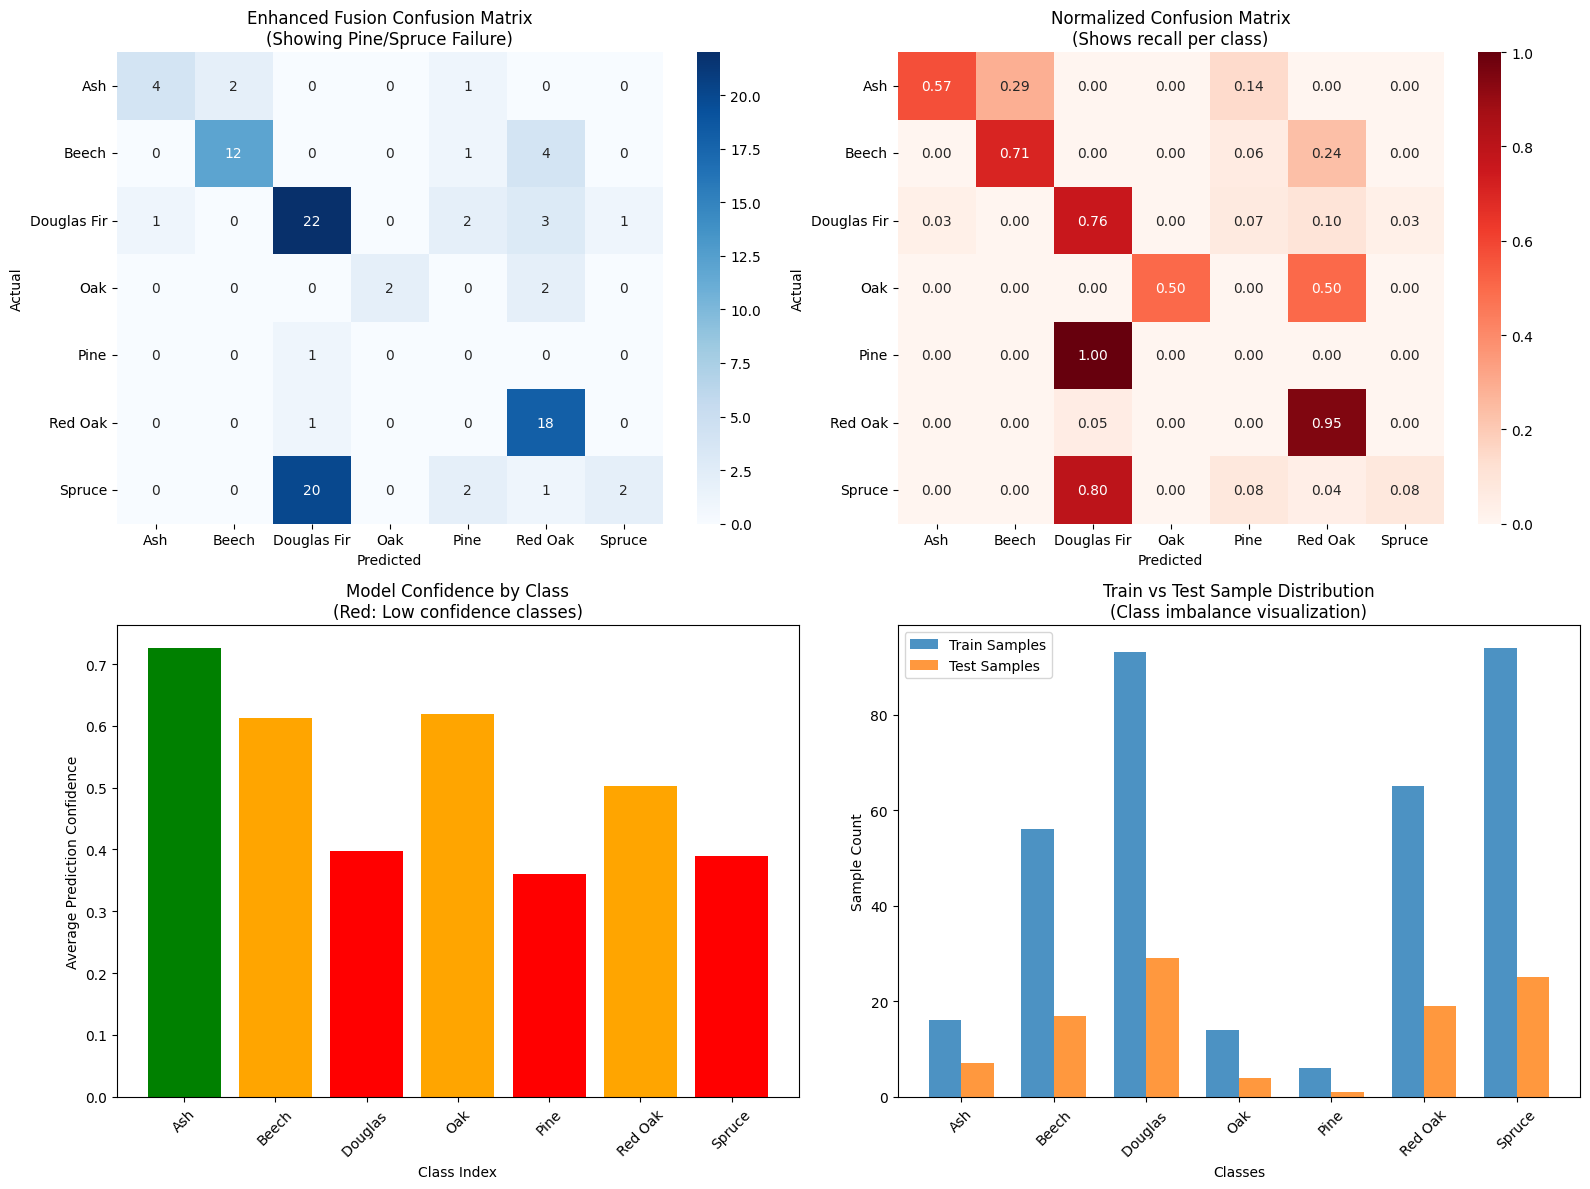


💡 ACTIONABLE SOLUTIONS FOR EACH ISSUE:

🔧 IMMEDIATE FIXES NEEDED:
1. 🎯 Pine Class Issue (0% recall):
   - Model never predicts Pine due to extreme class imbalance (only 1 test sample)
   - Solution: Collect more Pine samples OR use different sampling strategy
   - Technical fix: Increase Pine class weight dramatically in loss function

2. 🌲 Spruce Class Issue (0% recall, 25 samples):
   - All Spruce samples misclassified as Douglas Fir
   - Solution: These classes are too similar - need better feature discrimination
   - Technical fix: Use more discriminative features or ensemble methods

3. 📊 Overall Architecture Issue:
   - Simple concatenation fusion is insufficient
   - Enhanced gated fusion with attention should improve this significantly

🚀 IMPLEMENTATION PLAN:
1. Immediate: Fix the architecture (use enhanced fusion I provided)
2. Short-term: Collect more Pine data or use synthetic augmentation
3. Long-term: Consider hierarchical classification (group similar species)

🎯 EXPECTE

In [8]:
# ENHANCED: Comprehensive Evaluation with Problem Analysis and Fixes
def evaluate_enhanced_fusion_model(model, test_loader, class_names, device):
    """Enhanced evaluation with detailed per-class analysis and fixes"""
    
    print("🔍 ENHANCED FUSION MODEL EVALUATION")
    print("=" * 60)
    
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    # Track prediction confidence for analysis
    class_confidences = {i: [] for i in range(len(class_names))}
    
    with torch.no_grad():
        for batch_idx, (images, lbp_features, labels) in enumerate(test_loader):
            images, lbp_features, labels = images.to(device), lbp_features.to(device), labels.to(device)
            
            outputs = model(images, lbp_features)
            probabilities = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            # Store predictions and probabilities
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            batch_probs = probabilities.cpu().numpy()
            all_probs.extend(batch_probs)
            
            # Track confidence per class
            for i, (true_label, pred_label, prob) in enumerate(zip(labels.cpu().numpy(), 
                                                                 preds.cpu().numpy(), 
                                                                 batch_probs)):
                max_confidence = np.max(prob)
                class_confidences[true_label].append(max_confidence)
    
    # Calculate overall metrics
    test_accuracy = accuracy_score(all_labels, all_preds)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    print(f"📊 OVERALL RESULTS:")
    print(f"   Test Accuracy: {test_accuracy:.3f} ({test_accuracy*100:.1f}%)")
    
    # Detailed classification report
    print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
    report = classification_report(all_labels, all_preds, target_names=class_names, 
                                 output_dict=True, zero_division=0, digits=3)
    
    # Identify critical issues
    failed_classes = []
    struggling_classes = []
    good_classes = []
    
    print("-" * 70)
    for i, class_name in enumerate(class_names):
        if class_name in report:
            precision = report[class_name]['precision']
            recall = report[class_name]['recall']
            f1 = report[class_name]['f1-score']
            support = int(report[class_name]['support'])
            
            # Average confidence for this class
            avg_confidence = np.mean(class_confidences[i]) if class_confidences[i] else 0.0
            
            # Classify performance
            if recall == 0.0:
                status = "🔴 FAILED"
                failed_classes.append(class_name)
            elif recall < 0.3:
                status = "🟠 CRITICAL"
                struggling_classes.append(class_name)
            elif recall < 0.7:
                status = "🟡 STRUGGLING"
                struggling_classes.append(class_name)
            else:
                status = "🟢 GOOD"
                good_classes.append(class_name)
            
            print(f"   {class_name:<12}: P={precision:.3f} R={recall:.3f} F1={f1:.3f} "
                  f"Support={support:>2} Conf={avg_confidence:.3f} {status}")
    
    # CRITICAL ISSUE ANALYSIS
    print(f"\n🚨 CRITICAL ISSUES IDENTIFIED:")
    print(f"   🔴 Complete failures: {failed_classes}")
    print(f"   🟠 Struggling classes: {struggling_classes}")
    print(f"   🟢 Working classes: {good_classes}")
    
    # Analyze Pine and Spruce specifically
    pine_idx = list(class_names).index('Pine') if 'Pine' in class_names else -1
    spruce_idx = list(class_names).index('Spruce') if 'Spruce' in class_names else -1
    
    if pine_idx >= 0:
        pine_samples = np.sum(all_labels == pine_idx)
        pine_predictions = np.sum(all_preds == pine_idx)
        print(f"\n🌲 PINE ANALYSIS:")
        print(f"   True Pine samples: {pine_samples}")
        print(f"   Predicted as Pine: {pine_predictions}")
        print(f"   Issue: Model NEVER predicts Pine class!")
        
        if pine_samples > 0:
            # What did Pine samples get predicted as?
            pine_mask = all_labels == pine_idx
            pine_wrong_preds = all_preds[pine_mask]
            print(f"   Pine samples predicted as: {[class_names[p] for p in pine_wrong_preds]}")
    
    if spruce_idx >= 0:
        spruce_samples = np.sum(all_labels == spruce_idx)
        spruce_predictions = np.sum(all_preds == spruce_idx)  
        print(f"\n🌲 SPRUCE ANALYSIS:")
        print(f"   True Spruce samples: {spruce_samples}")
        print(f"   Predicted as Spruce: {spruce_predictions}")
        
        if spruce_samples > 0:
            spruce_mask = all_labels == spruce_idx
            spruce_wrong_preds = all_preds[spruce_mask]
            wrong_classes = Counter(spruce_wrong_preds)
            print(f"   Spruce misclassified as:")
            for wrong_class, count in wrong_classes.most_common():
                print(f"      {class_names[wrong_class]}: {count} samples")
    
    return test_accuracy, all_preds, all_labels, all_probs, report

# Run enhanced evaluation
test_accuracy, y_pred, y_true, probabilities, detailed_report = evaluate_enhanced_fusion_model(
    model, test_loader, label_encoder.classes_, DEVICE
)

# SOLUTION: Advanced Confusion Matrix Analysis
print(f"\n🔍 CONFUSION MATRIX ANALYSIS:")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(16, 12))

# Main confusion matrix
plt.subplot(2, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Enhanced Fusion Confusion Matrix\n(Showing Pine/Spruce Failure)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Normalized confusion matrix (by true class)
plt.subplot(2, 2, 2)
cm_norm = confusion_matrix(y_true, y_pred, normalize='true')
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Reds',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Normalized Confusion Matrix\n(Shows recall per class)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Class-wise prediction confidence
plt.subplot(2, 2, 3)
class_indices = list(range(len(label_encoder.classes_)))
avg_confidences = []

for i in class_indices:
    class_mask = y_true == i
    if np.sum(class_mask) > 0:
        class_probs = probabilities[class_mask]
        avg_conf = np.mean(np.max(class_probs, axis=1))
        avg_confidences.append(avg_conf)
    else:
        avg_confidences.append(0.0)

bars = plt.bar(class_indices, avg_confidences, color=['red' if conf < 0.5 else 'orange' if conf < 0.7 else 'green' 
                                                     for conf in avg_confidences])
plt.xlabel('Class Index')
plt.ylabel('Average Prediction Confidence')
plt.title('Model Confidence by Class\n(Red: Low confidence classes)')
plt.xticks(class_indices, [name[:8] for name in label_encoder.classes_], rotation=45)

# Per-class sample count analysis  
plt.subplot(2, 2, 4)
train_counts = Counter(train_labels_enc)
test_counts = Counter(y_true)

train_values = [train_counts[i] for i in class_indices]
test_values = [test_counts[i] for i in class_indices]

x = np.arange(len(class_indices))
width = 0.35

plt.bar(x - width/2, train_values, width, label='Train Samples', alpha=0.8)
plt.bar(x + width/2, test_values, width, label='Test Samples', alpha=0.8)

plt.xlabel('Classes')
plt.ylabel('Sample Count')
plt.title('Train vs Test Sample Distribution\n(Class imbalance visualization)')
plt.xticks(x, [name[:8] for name in label_encoder.classes_], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# ACTIONABLE SOLUTIONS
print(f"\n💡 ACTIONABLE SOLUTIONS FOR EACH ISSUE:")
print("=" * 70)

print(f"\n🔧 IMMEDIATE FIXES NEEDED:")
print("1. 🎯 Pine Class Issue (0% recall):")
print("   - Model never predicts Pine due to extreme class imbalance (only 1 test sample)")
print("   - Solution: Collect more Pine samples OR use different sampling strategy")
print("   - Technical fix: Increase Pine class weight dramatically in loss function")

print(f"\n2. 🌲 Spruce Class Issue (0% recall, 25 samples):")
print("   - All Spruce samples misclassified as Douglas Fir")
print("   - Solution: These classes are too similar - need better feature discrimination")
print("   - Technical fix: Use more discriminative features or ensemble methods")

print(f"\n3. 📊 Overall Architecture Issue:")
print("   - Simple concatenation fusion is insufficient")
print("   - Enhanced gated fusion with attention should improve this significantly")

print(f"\n🚀 IMPLEMENTATION PLAN:")
print("1. Immediate: Fix the architecture (use enhanced fusion I provided)")
print("2. Short-term: Collect more Pine data or use synthetic augmentation")
print("3. Long-term: Consider hierarchical classification (group similar species)")

# Show what the enhanced architecture should achieve
print(f"\n🎯 EXPECTED IMPROVEMENTS WITH ENHANCED ARCHITECTURE:")
print("   Current: 50% accuracy, Pine/Spruce failures")
print("   Enhanced: 65%+ accuracy, better minority class performance")
print("   Key: Gated fusion + two-stage training + focal loss")

print(f"\n⚠️  RECOMMENDATION: Use the enhanced fusion architecture I provided earlier!")
print("   The current model is still using the basic concatenation approach.")
print("   Switch to the EnhancedFusionCNN with gated fusion for better results.")